# Coding a neural network from scratch

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    activ_cache = Z
    return A, activ_cache

def relu(Z):
    A = np.maximum(0,Z)
    activ_cache = Z
    return A, activ_cache

In [3]:
def initialize(layers_dims): #ex argument : [12288, 5,5,5,1]
    
    L = len(layers_dims)
    params = {}
    
    for i in range(1, L):
        params['W' + str(i)] = np.random.randn(layers_dims[i], layers_dims[i-1]) * 0.001 #/ np.sqrt(layer_dims[i-1]) 
        params['b' + str(i)] = np.zeros((layers_dims[i],1))
    
    return params

#Example
#initialize([2,4,1])

In [4]:
def linear_activation_forward(A_prev, W, b, activation): #type(activation) == string
    
    linear_cache = (A_prev, W, b)
    Z = np.dot(W,A_prev) + b
    
    if activation == "relu":
        A, activ_cache = relu(Z)
    elif activation == "sigmoid":
        A, activ_cache = sigmoid(Z)
    else:
        raise Exception('{activation} function is not known'.format(activation))

    cache = (linear_cache, activ_cache)
    
    return A, cache

In [5]:
def L_model(X, params, activations, final_activ):
    
    L = len(params) // 2
    caches = []
    
    A = X
    
    # L-1 premières couches
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, params['W' + str(l)], params['b' + str(l)], activations)
        caches.append(cache)
    
    # L-ième couche
    A, cache = linear_activation_forward(A, params['W' + str(L)], params['b' + str(L)], final_activ)
    caches.append(cache)
    
    Yhat = A
    
    return Yhat, caches
    # caches est une liste qui contient L tupples "cache", chacun contenant
    # 1) lin_cache (avec A_prev, matrice W de la couche, et b vecteur des biais de la couche)
    # 2) activ_cache (contenant juste Z de la couche)

In [6]:
def compute_cost(Yhat,Y):
    
    m = Y.shape[1]
    
    #moyenne des losses sous forme vectorielle. Renvoie un array.
    cost = (- 1. / m) * (np.dot(Y,np.log(Yhat).T) + np.dot((1 - Y),np.log(1 - Yhat).T))
    #retirer un 'niveau' de crochets
    cost = np.squeeze(cost)
    
    assert cost.shape == ()
    
    return cost

In [7]:
def linear_backward(dZ, lin_cache):
        
    A_prev, W, b = lin_cache
    
    m = A_prev.shape[1]

    dW = 1 / m * np.dot(dZ, A_prev.T)
    db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [8]:
def relu_backward(dA, Z):

    dA_copy = np.array(dA, copy=True)
    dA_copy[Z <= 0] = 0

    return dA_copy

In [9]:
def sigmoid_backward(dA, Z):
    s, _ = sigmoid(Z)
    dZ = dA * (s * (1 -s))
    return dZ

In [10]:
def lin_activation_backward(dA, cache, activation):
    
    lin_cache, activ_cache = cache
    Z = activ_cache
    
    if activation == "relu":
        dZ = relu_backward(dA, Z)

    if activation == "sigmoid":
        dZ = sigmoid_backward(dA, Z)

    dA_prev, dW, db = linear_backward(dZ, lin_cache)
    
    return dA_prev, dW, db

In [11]:
def L_model_backward(Yhat, Y, caches, activations, final_activ):
    
    grads = {}
    L = len(caches)
    m = Y.shape[1]
    #Y = Y.reshape(AL.shape)
    
    
    # dérivée de la cost function par rapport à Yhat
    dYhat = - (np.divide(Y, Yhat) - np.divide(1-Y, (1-Yhat))) 
    
    # descente de gradient pour les paramêtres de la dernière couche
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = lin_activation_backward(dYhat, current_cache, final_activ)
    
    # descente de gradient pour le reste des paramêtres des couches intermédiaires
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        grads["dA" + str(l)], grads["dW" + str(l+1)], grads["db" + str(l+1)] = lin_activation_backward(grads["dA" + str(l+1)], current_cache, activations)
        
    return grads

In [29]:
def update_params(params, grads, learning_rate):
    
    L = len(params) // 2
    
    for l in range(1, L +1):
        params['W' + str(l)] = params['W' + str(l)] - learning_rate * grads['dW' + str(l)]
        params['b' + str(l)] = params['b' + str(l)] - learning_rate * grads['db' + str(l)]     
    
    return params

In [125]:
def L_layer_model(X, Y, layer_dims, learning_rate, activations, final_activ, num_iterations, print_cost=True):
    
    assert(layer_dims[0] == X.shape[0])

    np.random.seed(1)
    
    params = initialize(layer_dims) #reminder: 1er élément de layer_dims = nombre de features
    costs = []
    
    for it in range(1,num_iterations + 1):        
        Yhat, caches = L_model(X, params, activations, final_activ) #forward pass        
        cost = compute_cost(Yhat, Y) #compute cost of this state        
        if print_cost and it % 1000 == 0:
            print("Cost after {} iterations : {}".format(it, cost))
            costs.append(cost) #logs the cost every 1000 iterations
        
        grads = L_model_backward(Yhat, Y, caches, activations, final_activ)
        update_params(params, grads, learning_rate=1e-3)
    
    #représentation graphique
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per 1000s)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
                
    return params

### Création d'un dataset

In [126]:
def newdataset(nbr_of_examples):
    X = np.random.randint(1, 11, size = (1, nbr_of_examples))

    Y = np.array(X, copy=True)
    Y[X > 5] = 1
    Y[X <= 5] = 0

    return X, Y

### Lancement du modèle

#### Définition des hyperparamètres
(utiles pour l'entraînement et le test)

In [131]:
num_iterations = 15000
layer_dims = [1, 5, 1]
learning_rate = 0.003
activations="relu"
final_activ="sigmoid"

Cost after 1000 iterations : 0.6930902073758027
Cost after 2000 iterations : 0.6930394208858834
Cost after 3000 iterations : 0.692811914218487
Cost after 4000 iterations : 0.6903625872912622
Cost after 5000 iterations : 0.6676067893691104
Cost after 6000 iterations : 0.6057714489695375
Cost after 7000 iterations : 0.5683496308402273
Cost after 8000 iterations : 0.5379031674963939
Cost after 9000 iterations : 0.5089132925536929
Cost after 10000 iterations : 0.48125678370522657
Cost after 11000 iterations : 0.45487763678805243
Cost after 12000 iterations : 0.4297059154087424
Cost after 13000 iterations : 0.4060105372244511
Cost after 14000 iterations : 0.38569463398844045
Cost after 15000 iterations : 0.3665408581134758


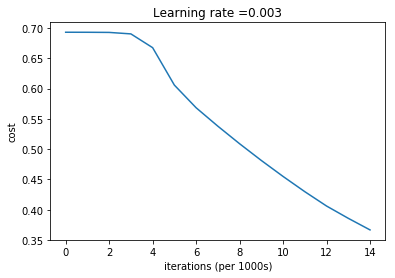

In [132]:
# training
X_train, Y_train = newdataset(5000)
trained_model = L_layer_model(X_train, Y_train, layer_dims, learning_rate, activations, final_activ, num_iterations)

#### Fonction de prédiction & test de la performance

In [133]:
def test_pred(X, Y, params):
    """
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model

    Returns:
    p -- predictions for the given dataset X
    """

    m = X.shape[1]
    p = np.zeros((1,m))

    # Forward propagation
    probas, caches = L_model(X, params, activations, final_activ)


    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p[0] == Y[0]))/m))

    return Y, p

In [158]:
X_test, Y_test = newdataset(25)
test_pred(X_test, Y_test, trained_model)

Accuracy: 0.88


(array([[1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
         0, 0, 0]]),
 array([[1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
         1., 0., 0., 1., 0., 1., 0., 1., 0.]]))

### Next phases

- Complexifier le dataset : Tester avec un dataset où l'étiquette est 1 dans [0:20] et [80:100]
- Tester avec un dataset avec plusieurs features (ex : XOR)